In [ ]:
# Download Dataset

https://drive.google.com/file/d/1DVkXCHvuu6mZnMq7enomsb7YSOZAvJBA/view?usp=sharing

In [18]:
!unzip -q archive.zip
!ls

archive.zip		    fer2013.bib        sample_data
emoji-creator-project-code  ferSubmission.csv  X_test_privatetest6_100pct.npy
fer20131.csv		    README


In [13]:
pip install brewer2mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


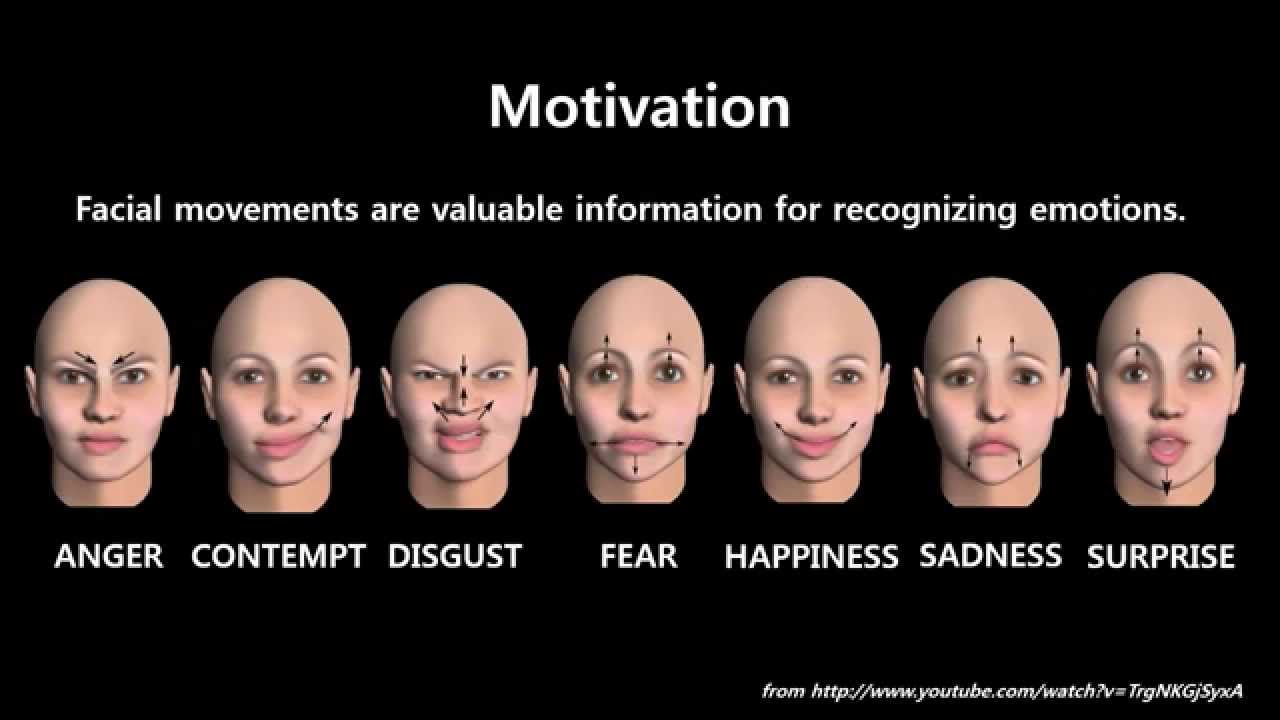

# 1. Data Preparation

Here, we obtaind the dataset from the Kaggle competition "Challenges in Representation Learning: Facial Expression Recognition Challenge". From Kaggle open resource, we had training dataset, public test dataset (which is then used as validation dataset for our project), and further a private dataset (same size with public test dataset and will be used as data for evaluating the prediction performance). It is noteworthy that in original provided dataset (either in training dataset or in public test dataset), we have actually in total 7 categories, apart from "Angry, Surprise, Fear, Happy, Sad and Neutral" that has been presented in our slides, we had an additional tag of "Disgust". However, the main problem will be that we have a quite unbalanced distribution of Disgust label in provided data, it accounts for a unusually low percentage, the obvious unbalance in data distribution will influence further neural network training, therefore we re-classify all pictures with "Disgust" label into "Angry" label. Such re-classification is relatively subjective, completely based on our perception of those two labels. Both of our teammates believe that the muscle movements in Angry face looks highly similar to that for Disgust faces.

In [14]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import brewer2mpl

In [19]:
def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [20]:
## All three datasets are well loaded accordingly
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


In [21]:
## The shape of loaded data is under examination
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 6)
(3589, 48, 48, 1)
(3589, 6)
(3589, 48, 48, 1)
(3589, 6)


After successfully loading the training, validation and testing dataset, we know had an input with dimension 48481, one channel is used since we only have greyscale picture instead of colorful pictures stored in RGB format, for output, we had 6 labels. Fot training dataset, we had a sample size as large as 28709 while validation as well as test dataset own a sample size of 3589. Overall, we had a pretty large dataset.

In [22]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (zip(labels, counts))

Private test set


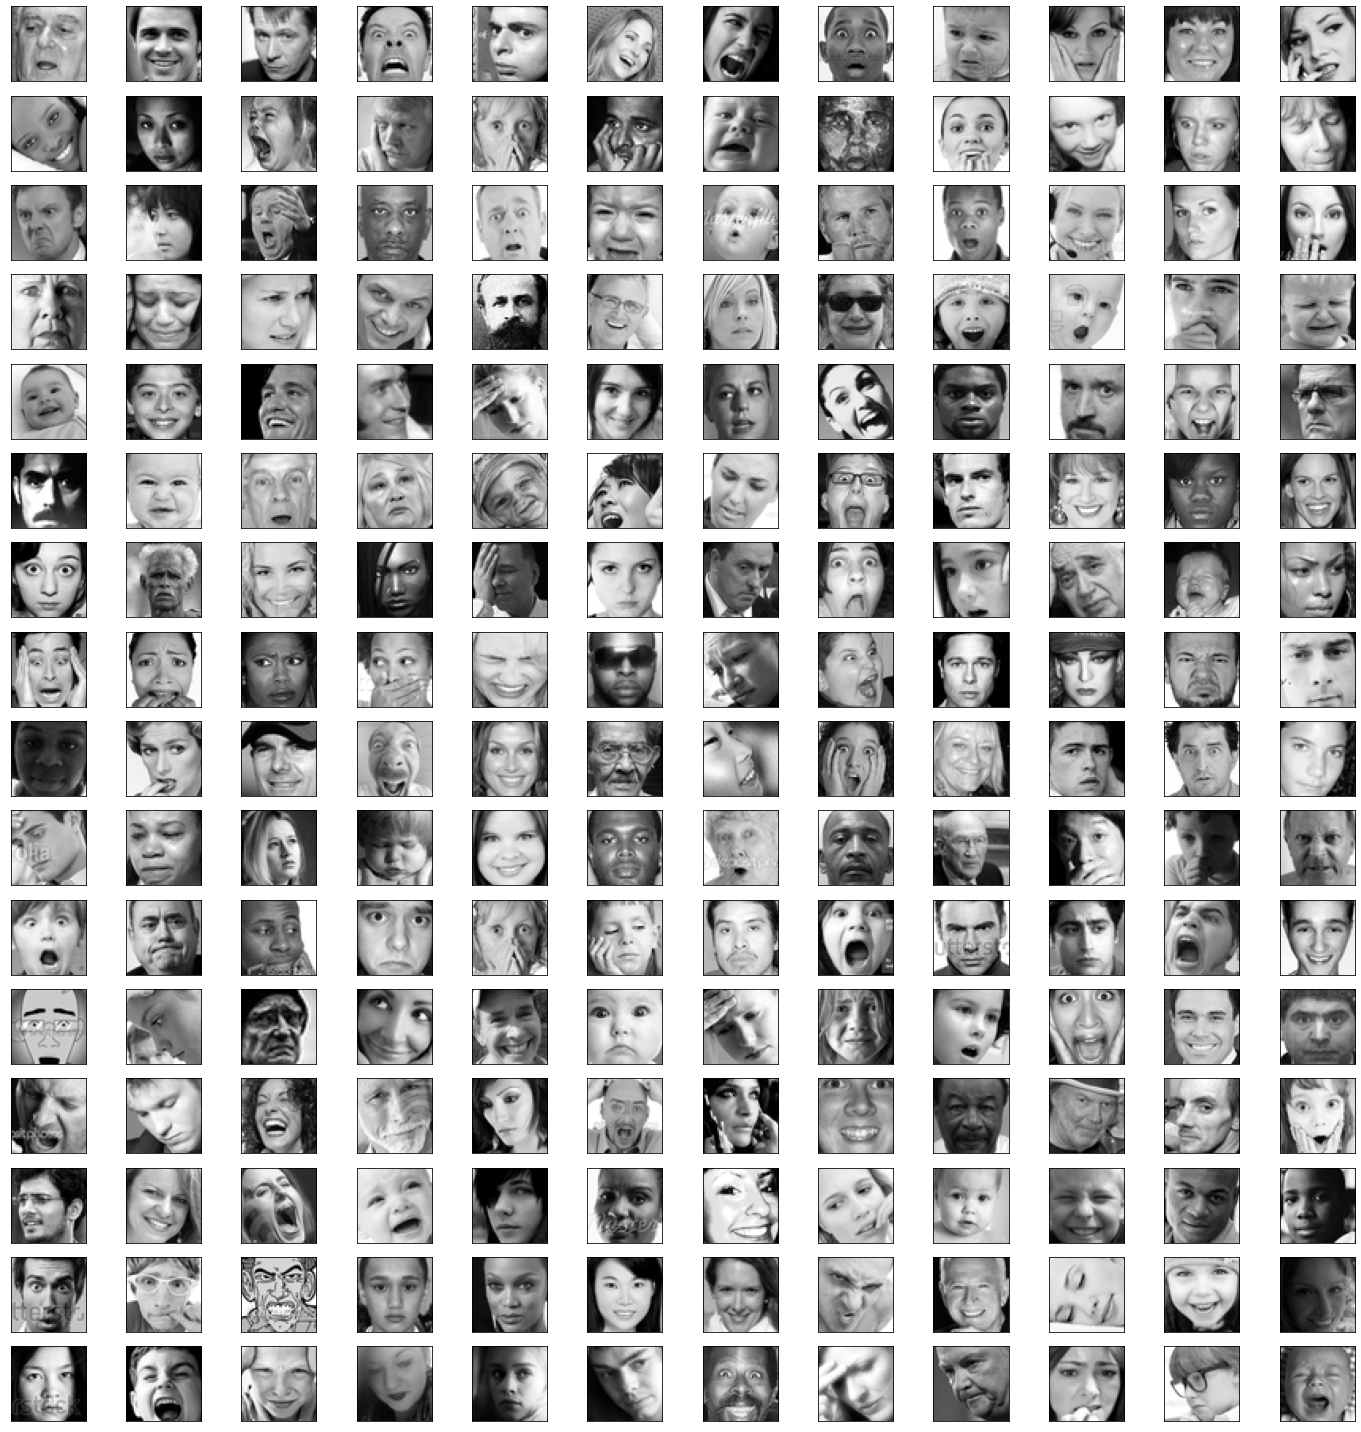

In [23]:
def overview(start, end, X):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,191, X)

(1, 48, 48, 1)


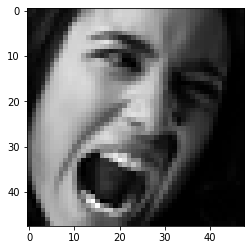

In [24]:
## Similarly we canvisualize any input with self-defined index with following code
input_img = X[6:7,:,:,:] 
print (input_img.shape)
plt.imshow(input_img[0,:,:,0], cmap='gray')
plt.show()

In [25]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

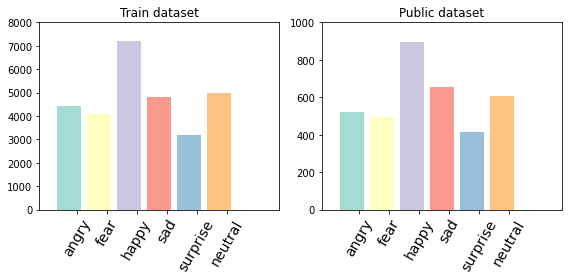

In [26]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000]) 

# 2. Model Architecture

Here, we first approached this project by specifying out clearly our primary purpose--classify provided greyscale pictures into one out of six labels. The picture classification task natually leads us to well-known Convolutional Neural Network (CNN). After researching around how CNN usually performs for greyscale picture, we decided to start from three sequential convolutional layers followed by a maxpooling layer, common activation function for convolutional layer "relu" is used, as well as the same padding pattern. Then, from the basic structure, we further added more and more convolutional layers with different features captured. The features to be captured from convolutional layer increased from 32 to 128, it is suggested that such hierarchical structure (with increasing layer nodes) performs better for deep neural network. Finally, the convolved layer is first flattened and then go through two more dense layers to reach the output layer in which softmax activation function is used for multiclass classification (six classes in total).

In [28]:
# Final Model Architecture:
from keras import layers
from keras import models
from keras import optimizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')


Training....


In [32]:
#fit
epochs = 32
batch_size = 128

modelF = modelN.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1)

Epoch 1/32
225/225 [==============================] - 20s 41ms/step - loss: 1.7554 - accuracy: 0.2511 - val_loss: 1.7299 - val_accuracy: 0.2636
Epoch 2/32
225/225 [==============================] - 9s 39ms/step - loss: 1.5882 - accuracy: 0.3477 - val_loss: 1.4369 - val_accuracy: 0.4260
Epoch 3/32
225/225 [==============================] - 9s 39ms/step - loss: 1.3874 - accuracy: 0.4464 - val_loss: 1.3084 - val_accuracy: 0.4873
Epoch 4/32
225/225 [==============================] - 9s 39ms/step - loss: 1.2527 - accuracy: 0.5097 - val_loss: 1.2226 - val_accuracy: 0.5247
Epoch 5/32
225/225 [==============================] - 9s 41ms/step - loss: 1.1461 - accuracy: 0.5542 - val_loss: 1.1643 - val_accuracy: 0.5508
Epoch 6/32
225/225 [==============================] - 9s 40ms/step - loss: 1.0578 - accuracy: 0.5949 - val_loss: 1.1341 - val_accuracy: 0.5717
Epoch 7/32
225/225 [==============================] - 9s 40ms/step - loss: 0.9777 - accuracy: 0.6260 - val_loss: 1.1117 - val_accuracy: 0.587

# 3. Model Evaluation

INFO:tensorflow:Assets written to: facial_1/assets


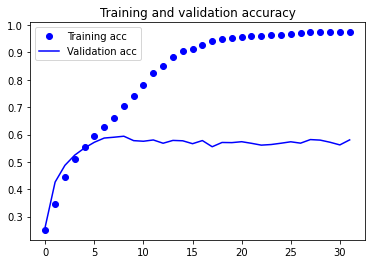

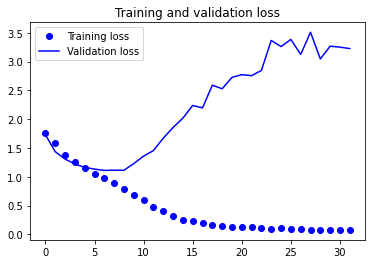

In [34]:
modelN.save('facial_1')

acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 58.74%


In [36]:
# prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [37]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [38]:
import brewer2mpl
def plot_probs(start,end, y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [43]:
import matplotlib
import matplotlib.pyplot as plt

In [39]:
def plot_subjects_with_probs(start, end, y_prob):
    """
    This plotting function is used to plot the probability together with its picture
    """
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

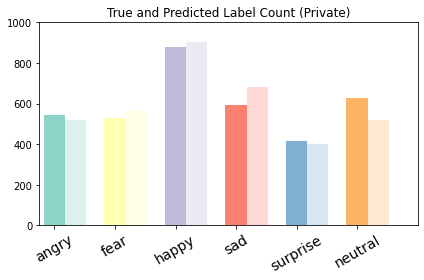

In [41]:
def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution2(y_true, y_pred)

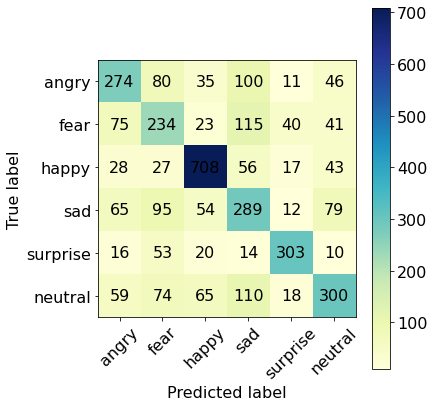

In [44]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

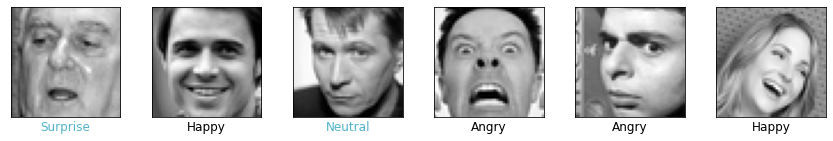

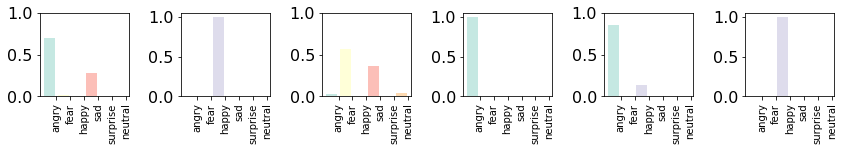

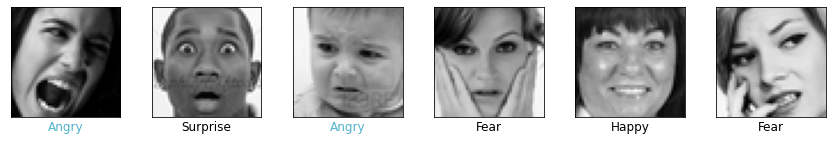

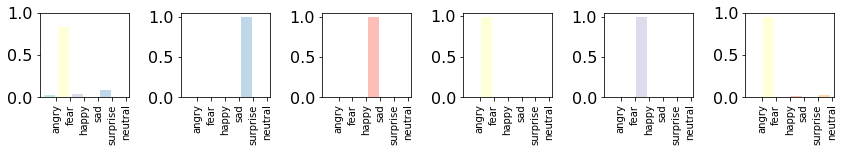

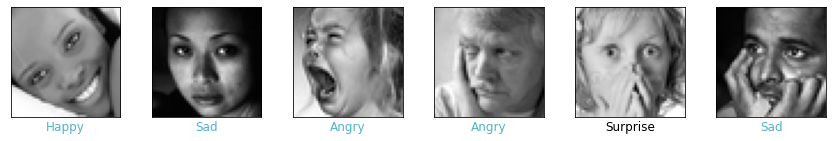

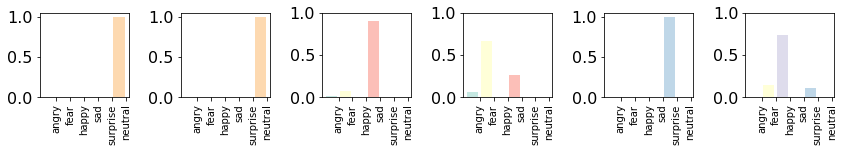

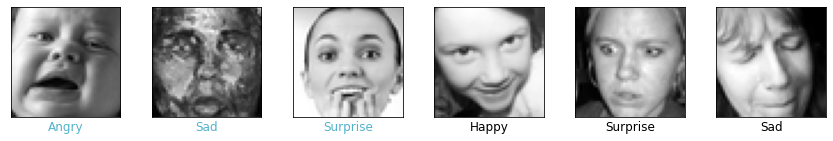

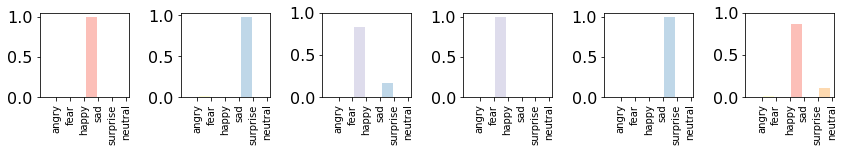

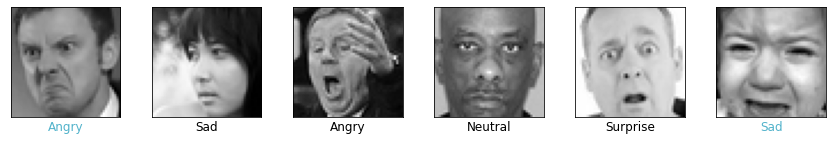

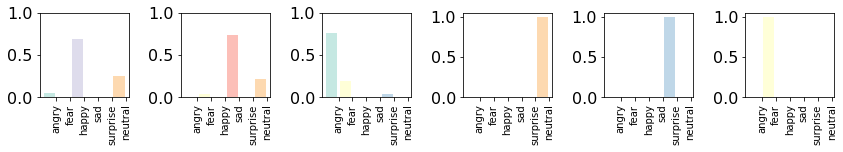

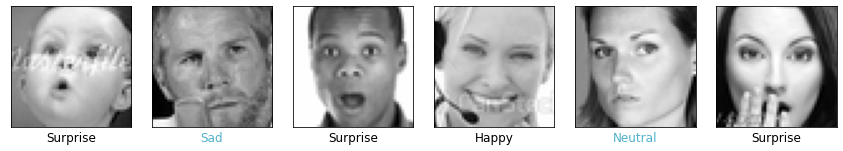

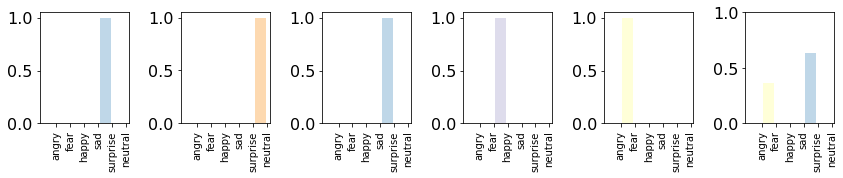

In [45]:
plot_subjects_with_probs(0, 36, y_prob)